# Detecting Midjourney Images via Feature Engineering & Classification

**Objectives**

- **Engineer Discriminative Features**
    
    Develop and extract features that effectively separate Stable Diffusion (AI-generated) images from authentic camera-captured photos using frequency, color, and texture analysis

- **Build Reproducible Pipeline**

    Construct a robust feature extraction pipeline that generates a tabular dataset suitable for ML. Ensure consistency and reproducibility across experiments.

- **Train & Evaluate Classifiers**

    Implement a classifier architectures such as Random Forest, XGBoost, SVM or Neural Networks. Rigorously evaluate performance using industry-standard metrics and confusion matrices

- **Quantify Feature Relevance**

    Apply multiple interpretability techniques such as Gini importance. Permutation importance, and SHAP values to understand which features drive classification decisions.
    


**Dataset Structure**
```bash
imagenet_midjourney/
|----test/ 
| |----ai/ 
| | |--[AI-generated images] (Stable Diffusion/Midjourney) 
| | Label: 1 (fake) 
| |----nature/ 
| | |--[Natural camera images] 
| | (Non-AI photographs) 
| | Label: 0 (real)
```

## Imports

In [29]:
import os
import cv2
import numpy as np
import pandas as pd

from skimage import io, color, img_as_ubyte
from tqdm import tqdm

from scipy.stats import linregress, gmean, pearsonr, kurtosis

from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score,
    recall_score, f1_score, classification_report
)

import matplotlib.pyplot as plt
import seaborn as sns

DATASET_DIR = "imagenet_midjourney/test"

# LABELS TO CLASSIFY IMAGES
CATEGORIES = {
    "ai": 1,
    "nature": 0
}

IMG_SIZE = (768, 768) # 768x768px to capture the features better
COLOR_MODE = 'rgb'

## Image Loading & Preprocessing

This function loads and preprocesses images, generating the feature matrix (`X`), corresponding labels (`y`), and file paths. 

For each image, it performs format validation, converts the data to either RGB or grayscale depending on the `color_mode` parameter, and ensures consistency across different image types. 

Each image is resized to 1024×1024 pixels and normalized to a [0, 1] range, standardizing inputs for subsequent machine learning workflows and improving model training stability.

In [30]:
def load_and_preprocess_images(base_dir, categories, img_size=(768, 768), color_mode='rgb'):
    X, y, paths = [], [], []

    #Loop through each category
    for category, label in categories.items():
        folder = os.path.join(base_dir, category)
        if not os.path.exists(folder):
            print(f"Folder not encountered: {folder}")
            continue

        for filename in tqdm(os.listdir(folder), desc=f"Loading {category}"):
            file_path = os.path.join(folder, filename)

            # Support common image formats
            if not filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.webp')):
                continue

            try:
                image = io.imread(file_path) # Image reading

                if color_mode == 'rgb':
                    if image.ndim == 2:
                        image = color.gray2rgb(image)
                    elif image.shape[2] == 4:
                        image = color.rgba2rgb(image)
                elif color_mode == 'gray':
                    image = color.rgb2gray(image)

                # Resize image
                image = cv2.resize(img_as_ubyte(image), img_size)

                # Normalizes [0, 1]
                image = image.astype(np.float32) / 255.0

                X.append(image)
                y.append(label)
                paths.append(file_path)
                
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue

    X = np.array(X)
    y = np.array(y)
    return X, y, paths

In [31]:
X, y, image_paths = load_and_preprocess_images(DATASET_DIR, CATEGORIES, IMG_SIZE, COLOR_MODE)

print(f"Total images loaded: {len(X)}")
print(f"Example [0]: {X[0].shape}")

Loading nature: 100%|██████████| 500/500 [00:04<00:00, 122.49it/s]


Total images loaded: 1000
Example [0]: (768, 768, 3)


## Feature Computation

Extract per-image features across frequency, color, and texture domains. Generate comprehensive feature vectors for each sample.

### Feature Family I: Frequency & Spectrum Analysis (FFT)

This function extracts 4 frequency features from an image using the Fast Fourier Transform (FFT) to capture its structural and textural properties:

1. `radial_power_spectrum_mean`:

    Represents the average energy distributed across spatial frequencies, reflecting the overall level of texture or detail in the image. Higher values suggest more complex visual patterns.

2. `spectral_slope`: 

    Obtained from the linear regression between log power and log frequency; it describes how quickly energy decays across frequencies. A steep negative slope indicates smoother images, while flatter slopes imply higher texture complexity.

3. `spectral_flatness`: 

    Measures how uniform the frequency distribution is. Values near 1 indicate white-noise-like textures (flat spectrum), whereas lower values reveal dominant frequencies or structured patterns.

4. `high_freq_ratio`: 

    Quantifies the proportion of energy contained in higher frequencies compared to the total energy. This captures the sharpness and fine detail content of the image, with higher ratios corresponding to crisper, more detailed visuals.


In [32]:
def compute_fft_features(image):
    # RGB  to Grayscale
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)
    gray = gray.astype(np.float32) / 255.0

    # Compute 2D FFT
    fft2 = np.fft.fft2(gray)
    fshift = np.fft.fftshift(fft2)
    magnitude_spectrum = np.abs(fshift) ** 2

    # Center coordinates
    rows, cols = gray.shape
    crow, ccol = rows // 2, cols // 2

    # Distance pixels from center
    y, x = np.ogrid[:rows, :cols]
    radius = np.sqrt((x - ccol) ** 2 + (y - crow) ** 2).astype(np.int32)

    # Average magnitude for each radius
    radial_profile = np.bincount(radius.ravel(), magnitude_spectrum.ravel()) / np.bincount(radius.ravel())
    radial_profile = radial_profile[1:]

    radial_power_spectrum_mean = np.mean(radial_profile)

    # Spectral slope
    freqs = np.arange(1, len(radial_profile) + 1)
    log_freqs = np.log(freqs)
    log_power = np.log(radial_profile + 1e-8)
    slope, intercept, _, _, _ = linregress(log_freqs, log_power)
    spectral_slope = slope

    # Spectral flatness
    spectral_flatness = gmean(radial_profile + 1e-8) / (np.mean(radial_profile) + 1e-8)

    # High-frequency energy ratio
    cutoff = len(radial_profile) // 3
    high_freq_energy = np.sum(radial_profile[-cutoff:])
    total_energy = np.sum(radial_profile)
    high_freq_ratio = high_freq_energy / (total_energy + 1e-8)

    return {
        'radial_power_spectrum_mean': radial_power_spectrum_mean,
        'spectral_slope': spectral_slope,
        'spectral_flatness': spectral_flatness,
        'high_freq_ratio': high_freq_ratio
    }


### Feature Family II: Colo & Chrominance Analysis

This set of functions extracts color-based statistical features that describe inter-channel relationships and chromatic texture. The helper functions safe_pearsonr and safe_kurtosis provide robust correlation and kurtosis calculations that safely handle near-constant or invalid data without producing NaNs. The main function, compute_color_features, derives six metrics:

1. `rgb_corr_mean`:
    
    The average Pearson correlation among the R, G, and B channels, indicating how similar their intensity variations are. High values suggest color homogeneity, while lower ones reflect richer color diversity.

2. `rgb_corr_std`:

    The standard deviation of those correlations, capturing how unevenly the color channels relate to each other.

3. `cb_kurtosis and cr_kurtosis`:
 
    Measure the peakedness or tailedness of the chroma component distributions in the YCbCr color space, reflecting color concentration or dispersion.

4. `cb_residual_kurtosis and cr_residual_kurtosis`:

    Computed from the Laplacian-filtered chroma channels, these quantify the sharpness and local variations in color texture, offering insight into how abrupt or smooth the chromatic transitions are within the image.

In [33]:
def safe_pearsonr(a, b):
    # 0 if std deviation is too low
    if np.std(a) < 1e-8 or np.std(b) < 1e-8:
        return 0.0
    
    # Compute Pearson correlation
    r, _ = pearsonr(a, b)
    return np.nan_to_num(r, nan=0.0, posinf=0.0, neginf=0.0)

def safe_kurtosis(x):
    # 0 if data is constant or std deviation is too low
    if x.size == 0 or np.allclose(x, x.flat[0], atol=1e-8) or np.std(x) < 1e-8:
        return 0.0
    
    # Compute kurtosis
    val = kurtosis(x, fisher=False)
    return np.nan_to_num(val, nan=0.0, posinf=0.0, neginf=0.0)

def compute_color_features(image):
    # Normalize to 8-bit [0, 255]
    img_8bit = (image * 255).astype(np.uint8)

    # RGB channel correlations
    R = img_8bit[:, :, 0].astype(np.float32).ravel()
    G = img_8bit[:, :, 1].astype(np.float32).ravel()
    B = img_8bit[:, :, 2].astype(np.float32).ravel()

    corr_rg = safe_pearsonr(R, G)
    corr_rb = safe_pearsonr(R, B)
    corr_gb = safe_pearsonr(G, B)
    
    rgb_corr_mean = np.mean([corr_rg, corr_rb, corr_gb])
    rgb_corr_std = np.std([corr_rg, corr_rb, corr_gb])

    ycbcr = cv2.cvtColor(img_8bit, cv2.COLOR_RGB2YCrCb)
    Y, Cr, Cb = cv2.split(ycbcr)  
    
    # Chrominance channel kurtosis
    cb_kurt = safe_kurtosis(Cb.ravel())
    cr_kurt = safe_kurtosis(Cr.ravel())

    # Laplacian residuals
    cb_lap = cv2.Laplacian(Cb.astype(np.float32), cv2.CV_32F, ksize=3)
    cr_lap = cv2.Laplacian(Cr.astype(np.float32), cv2.CV_32F, ksize=3)

    cb_lap = np.clip(cb_lap, -5000, 5000)
    cr_lap = np.clip(cr_lap, -5000, 5000)

    # Kurtosis of Laplacian residuals
    cb_residual_kurt = safe_kurtosis(cb_lap.ravel())
    cr_residual_kurt = safe_kurtosis(cr_lap.ravel())

    return {
        'rgb_corr_mean': rgb_corr_mean,
        'rgb_corr_std': rgb_corr_std,
        'cb_kurtosis': cb_kurt,
        'cr_kurtosis': cr_kurt,
        'cb_residual_kurtosis': cb_residual_kurt,
        'cr_residual_kurtosis': cr_residual_kurt
    }

### Feature Family III: 

The four GLCM-based features quantify different aspects of an image’s texture and spatial structure:

1. `Contrast`:

    Measures the intensity difference between neighboring pixels. High contrast values indicate sharp transitions and coarse textures, while low values suggest smoother, more uniform areas.

2. `Homogeneity`:

    Reflects how close the distribution of co-occurring gray levels is to the GLCM diagonal. Higher homogeneity means the image has consistent intensity patterns with minimal local variation.

3. `Energy`:

    Represents the sum of squared GLCM values, describing textural uniformity. Images with repetitive, orderly textures (like grids or smooth surfaces) exhibit higher energy.

4. `Correlation`:

    Quantifies the linear relationship between pixel pairs. Strong correlation implies predictable patterns or structured textures, whereas weak correlation points to randomness or noise.

In [34]:
def compute_glcm_features(image, levels=64, distances=[1, 2, 4], angles=None):

    if angles is None:
        angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]

    # Convert normalize to 8-bit grayscale
    gray = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_RGB2GRAY)

    # Quantize grayscale image
    gray_q = np.floor(gray / (256 / levels)).astype(np.uint8)

    # Compute GLCM
    glcm = graycomatrix(
        gray_q,
        distances=distances,
        angles=angles,
        levels=levels,
        symmetric=True,
        normed=True
    )

    # Compute GLCM properties
    props = {}
    for prop in ['contrast', 'homogeneity', 'energy', 'correlation']:
        vals = graycoprops(glcm, prop)
        props[prop] = np.mean(vals)

    # Handle NaN or Inf values
    for k in props:
        if np.isnan(props[k]) or np.isinf(props[k]):
            props[k] = 0.0

    return props

## Tabular Dataset Creation

In [35]:
fft_feature_list = []
color_features_list = []
glcm_feature_list = []


# FEATURE EXTRACTION
for img in tqdm(X, desc="Extracting features"):
    fft = compute_fft_features(img)
    color = compute_color_features(img)
    texture = compute_glcm_features(img)

    fft_feature_list.append(list(fft.values()))
    color_features_list.append(list(color.values()))
    glcm_feature_list.append(list(texture.values()))

fft_features = np.array(fft_feature_list)
color_features = np.array(color_features_list)
texture_features = np.array(glcm_feature_list)

# Handle any remaining NaN or Inf values
fft_features = np.nan_to_num(fft_features, nan=0.0, posinf=0.0, neginf=0.0)
color_features = np.nan_to_num(color_features, nan=0.0, posinf=0.0, neginf=0.0)
texture_features = np.nan_to_num(texture_features, nan=0.0, posinf=0.0, neginf=0.0)

print(f"FFT features shape: {fft_features.shape}")
print(f"Color features shape: {color_features.shape}")
print(f"GLCM features shape: {texture_features.shape}")
print("NaN restantes:", np.isnan(texture_features).sum())

Extracting features: 100%|██████████| 1000/1000 [02:41<00:00,  6.20it/s]

FFT features shape: (1000, 4)
Color features shape: (1000, 6)
GLCM features shape: (1000, 4)
NaN restantes: 0


In [36]:
X_features = np.concatenate([fft_features, color_features, texture_features], axis=1)

print(f"Feature matrix shape: {X_features.shape}")

Feature matrix shape: (1000, 14)


In [37]:
# CREATE DATAFRAME
fft_cols = list(fft.keys())
color_cols = list(color.keys())
texture_cols = list(texture.keys())

columns = fft_cols + color_cols + texture_cols

df_features = pd.DataFrame(X_features, columns=columns)
df_features['label'] = y

df_features.to_csv("image_features_dataset.csv", index=False)
print("Dataset stored: 'image_features_dataset.csv'")
print(df_features.head())

Dataset stored: 'image_features_dataset.csv'
   radial_power_spectrum_mean  spectral_slope  spectral_flatness  \
0                1.717294e+06       -3.608987           0.000349   
1                1.938156e+06       -2.994268           0.001044   
2                1.205291e+06       -3.250838           0.000325   
3                2.608236e+06       -4.141227           0.000105   
4                1.247449e+06       -4.379985           0.000067   

   high_freq_ratio  rgb_corr_mean  rgb_corr_std  cb_kurtosis  cr_kurtosis  \
0     3.785855e-06       0.980566      0.011761     5.470315     3.613757   
1     3.180926e-05       0.960995      0.023086     3.261434     3.310877   
2     7.828724e-06       0.934688      0.040791     7.167858     5.576611   
3     9.585360e-07       0.732338      0.179723     3.529076     3.417857   
4     5.556839e-07       0.804566      0.011719     3.412600     2.297771   

   cb_residual_kurtosis  cr_residual_kurtosis   contrast  homogeneity  \
0         

## Train/Test Splitting

In [38]:
df_features = pd.read_csv("image_features_dataset.csv")

X = df_features.drop("label", axis=1).values
y = df_features["label"].values

# DATA SPLIT
# 80 / 20 stratified split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"Train samples: {X_train.shape[0]}")
print(f"Test samples: {X_test.shape[0]}")
print(f"Class distribution (train): {np.bincount(y_train)}")
print(f"Class distribution (test): {np.bincount(y_test)}")

# CROSS-VALIDATION SETUP 5 FOLDS
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-validation setup:")
print(cv)

Train samples: 800
Test samples: 200
Class distribution (train): [400 400]
Class distribution (test): [100 100]

Cross-validation setup:
StratifiedKFold(n_splits=5, random_state=42, shuffle=True)


## Classifier Training

### Random Forest

In [39]:
# Param grid 
rf_param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# GRID SEARCH
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=rf_param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train, y_train) # Training
rf_best = rf_grid.best_estimator_

# Metrics
print("Best Random Forest params:", rf_grid.best_params_)
print("RF CV F1 Score:", rf_grid.best_score_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Random Forest params: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
RF CV F1 Score: 0.9000216397410398


### XGBoost

In [40]:
# Param grid
xgb_param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 400, 600],
    'max_depth': [3, 5, 8],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42,
    n_jobs=-1
)

# GRID SEARCH
xgb_grid = GridSearchCV(
    estimator=xgb,
    param_grid=xgb_param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

xgb_grid.fit(X_train, y_train) # Training
xgb_best = xgb_grid.best_estimator_

print("Best XGBoost params:", xgb_grid.best_params_)
print("XGBoost CV F1:", xgb_grid.best_score_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


c:\Users\polpu\Desktop\GitHub Repositories\detect-AI-midjourney-images\venv\Lib\site-packages\xgboost\training.py:199: UserWarning: [18:48:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best XGBoost params: {'colsample_bytree': 1.0, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 600, 'subsample': 0.8}
XGBoost CV F1: 0.9105691552244176


In [41]:
# Pipeline to scale for SVM
svm_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf'))
])

# Param grid
svm_param_grid = {
    'svm__C': [0.1, 1, 10, 100],
    'svm__gamma': ['scale', 0.1, 0.01, 0.001]
}

# GRID SEARCH
svm_grid = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=svm_param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(X_train, y_train) # Training
svm_best = svm_grid.best_estimator_

# Metrics
print("Best SVM params:", svm_grid.best_params_)
print("SVM CV F1:", svm_grid.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best SVM params: {'svm__C': 100, 'svm__gamma': 0.01}
SVM CV F1: 0.8816898377829567


## Evaluation & Interpretation


RandomForest:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       100
           1       0.90      0.91      0.91       100

    accuracy                           0.91       200
   macro avg       0.91      0.91      0.90       200
weighted avg       0.91      0.91      0.90       200



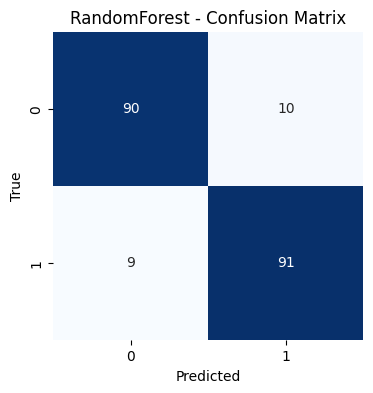


XGBoost:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90       100
           1       0.92      0.88      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



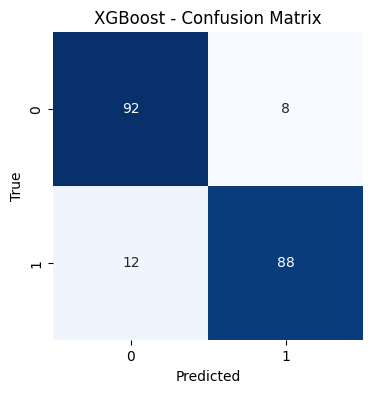


SVM-RBF:
              precision    recall  f1-score   support

           0       0.88      0.93      0.90       100
           1       0.93      0.87      0.90       100

    accuracy                           0.90       200
   macro avg       0.90      0.90      0.90       200
weighted avg       0.90      0.90      0.90       200



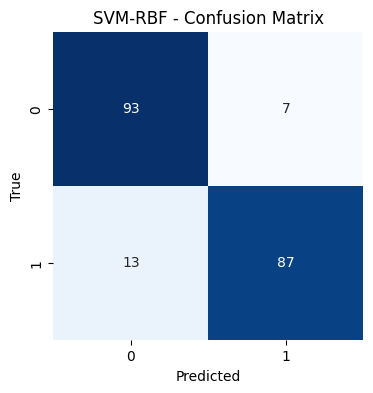


Summary of model performance:


,Model,Accuracy,Precision,Recall,F1
0,RandomForest,0.905,0.900990,0.91,0.905473
1,XGBoost,0.900,0.916667,0.88,0.897959
2,SVM-RBF,0.900,0.925532,0.87,0.896907


In [42]:
models = {
    "RandomForest": rf_best,
    "XGBoost": xgb_best,
    "SVM-RBF": svm_best
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred) # Accuracy
    prec = precision_score(y_test, y_pred) # Precision
    rec = recall_score(y_test, y_pred) # Recall
    f1 = f1_score(y_test, y_pred) # F1 Score
    cm = confusion_matrix(y_test, y_pred) # Confusion Matrix

    results.append({
        "Model": name,
        "Accuracy": acc,
        "Precision": prec,
        "Recall": rec,
        "F1": f1
    })

    print(f"\n{name}:")
    print(classification_report(y_test, y_pred)) # Metrics
    
    # Confusion Matrix
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

metrics_df = pd.DataFrame(results)
print("\nSummary of model performance:")
display(metrics_df)


Random Forest - Top 14 Features by Importance:
1. spectral_slope: 0.2588
2. cr_residual_kurtosis: 0.1281
3. high_freq_ratio: 0.1086
4. cb_residual_kurtosis: 0.0951
5. homogeneity: 0.0696
6. energy: 0.0607
7. spectral_flatness: 0.0534
8. correlation: 0.0415
9. contrast: 0.0409
10. radial_power_spectrum_mean: 0.0327
11. cb_kurtosis: 0.0308
12. cr_kurtosis: 0.0286
13. rgb_corr_mean: 0.0257
14. rgb_corr_std: 0.0255


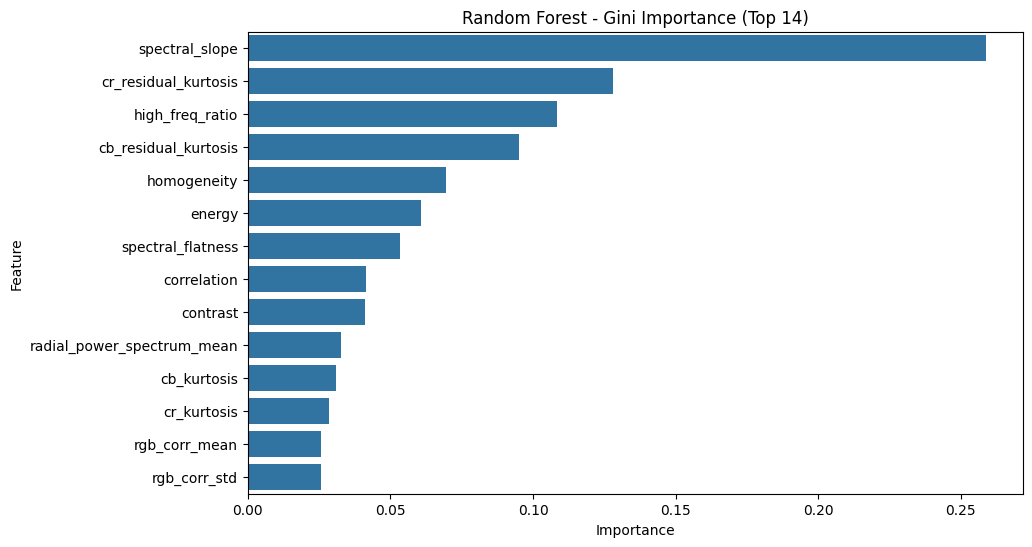


XGBoost - Top 14 Features by Importance:
1. spectral_slope: 0.2769
2. cr_residual_kurtosis: 0.1669
3. homogeneity: 0.0881
4. cb_residual_kurtosis: 0.0755
5. energy: 0.0602
6. contrast: 0.0478
7. radial_power_spectrum_mean: 0.0459
8. spectral_flatness: 0.0435
9. rgb_corr_mean: 0.0408
10. cb_kurtosis: 0.0405
11. rgb_corr_std: 0.0380
12. cr_kurtosis: 0.0275
13. correlation: 0.0258
14. high_freq_ratio: 0.0226


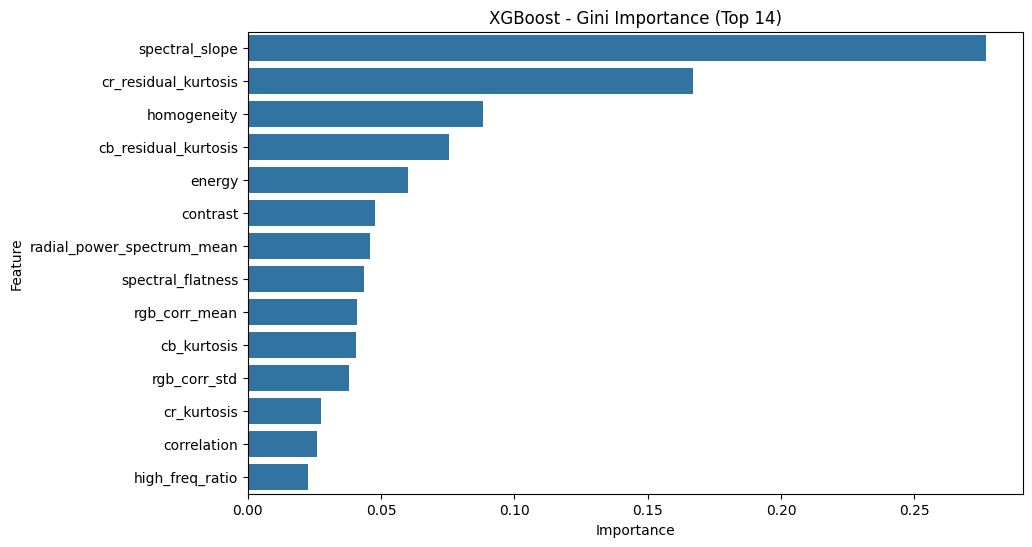

In [43]:
# Feature Importance Plotting

def plot_feature_importance(model, model_name, feature_names, top_n=15):
    importances = model.feature_importances_ # Gini importance

    n_features = len(feature_names)
    top_n = min(top_n, n_features)

    indices = np.argsort(importances)[::-1][:top_n] # Top N indices

    # Print top N features
    print(f"\n{model_name} - Top {top_n} Features by Importance:")
    for i in range(top_n):
        feature = feature_names[indices[i]]
        importance = importances[indices[i]]
        print(f"{i+1}. {feature}: {importance:.4f}")

    plt.figure(figsize=(10, 6))
    sns.barplot(x=importances[indices], y=np.array(feature_names)[indices])
    plt.title(f"{model_name} - Gini Importance (Top {top_n})")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

# Random Forest
plot_feature_importance(rf_best, "Random Forest", columns)

# XGBoost
plot_feature_importance(xgb_best, "XGBoost", columns)


Random Forest - Top 14 Features by Permutation Importance:
1. spectral_slope: 0.201500
2. cr_residual_kurtosis: 0.137500
3. cb_residual_kurtosis: 0.022500
4. homogeneity: 0.015000
5. high_freq_ratio: 0.004500
6. energy: 0.003500
7. cb_kurtosis: -0.002000
8. radial_power_spectrum_mean: -0.002000
9. correlation: -0.003000
10. contrast: -0.004000
11. rgb_corr_mean: -0.004000
12. rgb_corr_std: -0.004500
13. spectral_flatness: -0.005000
14. cr_kurtosis: -0.006000


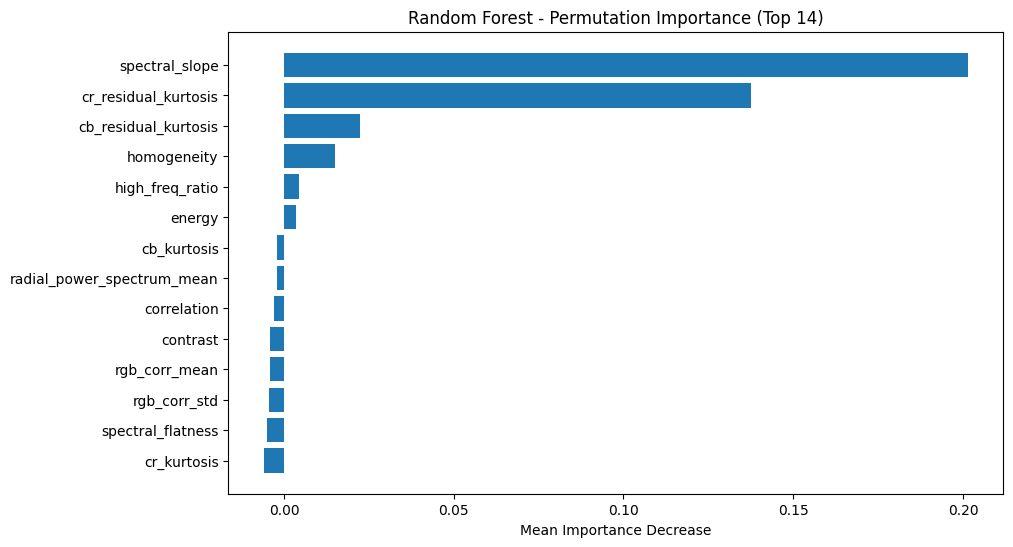


XGBoost - Top 14 Features by Permutation Importance:
1. spectral_slope: 0.230000
2. cr_residual_kurtosis: 0.147000
3. cb_residual_kurtosis: 0.030000
4. homogeneity: 0.028000
5. contrast: 0.022000
6. rgb_corr_mean: 0.019500
7. cb_kurtosis: 0.010500
8. high_freq_ratio: 0.008500
9. rgb_corr_std: 0.005500
10. radial_power_spectrum_mean: 0.003000
11. correlation: 0.000000
12. cr_kurtosis: -0.001000
13. energy: -0.003500
14. spectral_flatness: -0.006500


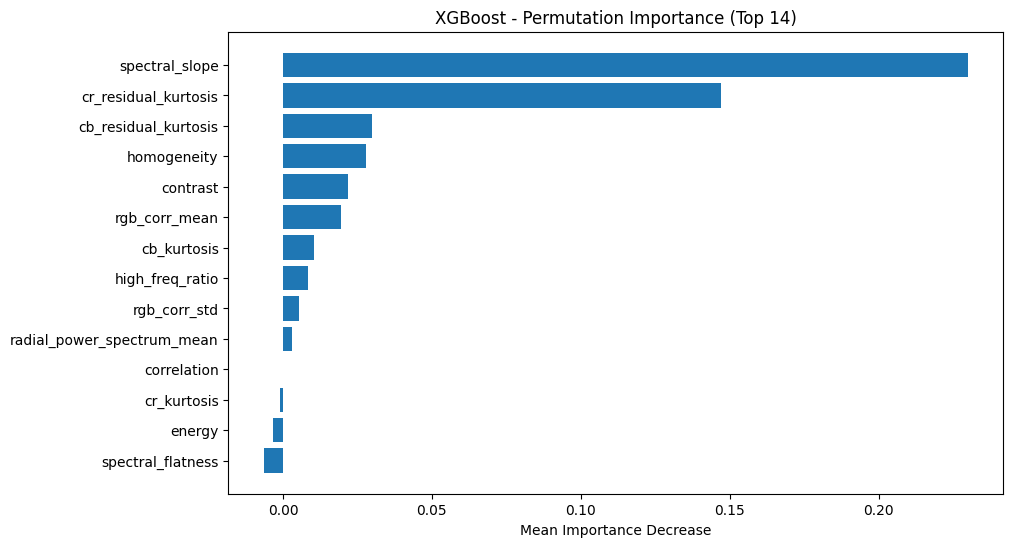

In [44]:
# Permutation Importance Plotting

from sklearn.inspection import permutation_importance

def permutation_importance_plot(model, X, y, feature_names, model_name, top_n=15):
    # Compute permutation importance
    result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
    
    # Get mean importances
    importances_mean = result.importances_mean
    n_features = len(feature_names)
    top_n = min(top_n, n_features)

    sorted_idx = np.argsort(importances_mean)[-top_n:]

    # Print top N features
    print(f"\n{model_name} - Top {top_n} Features by Permutation Importance:")
    for rank, idx in enumerate(sorted_idx[::-1], 1):
        feature = feature_names[idx]
        importance = importances_mean[idx]
        print(f"{rank}. {feature}: {importance:.6f}")

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[sorted_idx], importances_mean[sorted_idx])
    plt.xlabel("Mean Importance Decrease")
    plt.title(f"{model_name} - Permutation Importance (Top {top_n})")
    plt.show()

permutation_importance_plot(rf_best, X_test, y_test, columns, "Random Forest")
permutation_importance_plot(xgb_best, X_test, y_test, columns, "XGBoost")
